# **Coursework 1: Train a Propaganda Sentence Classifier**
In this course work, you are asked to train a sentiment analysis classifier for movie reviews. The sample code below builds a simple classifier that uses tf-idf to vectorize text and a logistic regression model to make predictions.

## **Table of Contents**

 1. [Introduction](#1)


 2. [Initial Analysis](#2)  
 
 
 3. [Cleaning](#3)  
 
     i. [Removing Punctuations](#3a)  
     ii. [Sequence Analysis](#3b)
 

 4. [Data Split & Vectorizer](#4)
 
     i. [Train-Text Split](#4a)  
     ii. [Tf-Idf Vectorizer](#4b)  
     iii. [Word-to-Vec](#4c)  


 5. [Neural Network Architectures](#5)  
 
 i. [Simple DNN](#5a)  
 ii. [RNN (Recurrent Neural Network)](#5c)  
     - [Basic RNN](#5c1)
     - [LSTM](#5c2)
     - [Bi-LSTM](#5c3)
     - [Bi-GRU](#5c4)
     
 iii. [CNN (Convolutional Neural Network)](#5b)  
 iv. [Convolutional Recurrent Neural Network with pre-trained embeddings](#5d)  
 v. [Custom Embeddings Convolutional Recurrent Neural Network](#5e)  



 6. [Final Model Build](#6)

<a id="1"></a>
## **1. Introduction**

This purpose of this assignment is to build a scentence propaganda classifier for movie reviews, which can take a piece of scentence as input and predict where the scentence consists any propaganda or not (prpoaganda or non-propaganda). This report explains the analysis of the dataset, the feature seleections method and final model building procedure using one of many algorithms. The overall process is implemented in Python.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils import shuffle
from tqdm import tqdm, notebook

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils import shuffle
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import copy
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

<a id="2"></a>
## **2. Initial Analysis**

In [2]:
# load data
df = pd.read_table('coursework2_train.tsv')
df = shuffle(df) # randomly shuffle data entries 
df

,article_id,article_title,label,sentence_text
8756,763440871,MAJOR NEW STUDY: Homeschooling Spikes Due to S...,non-propaganda,We have a daughter still in high school and th...
1756,728343601,Chile 'cover-up' letter contradicts Pope,propaganda,"In that letter, Mr Cruz accuses Bishop Barros ..."
7904,780786973,"Mueller is ‘looking for trouble,’ Trump says c...",non-propaganda,Mueller also is looking at whether some of Tru...
174,727493378,Coroner Defies Court Order: Won't Release Las ...,propaganda,"Seriously, it's been four months already!"
5604,738207834,"Et Tu, Benedict?",non-propaganda,Don’t we all want to know why Hans Kung is sti...
...,...,...,...,...
5613,738207834,"Et Tu, Benedict?",propaganda,"Maike Hickson quotes him, writing of this biza..."
11010,723844295,Lawmaker makes shocking claim about the Vegas ...,non-propaganda,"ISIS terrorists, he said, infiltrated the U.S...."
11407,777488669,"The Death Penalty, Instituted by God Himself (...",non-propaganda,"If his contrition is perfect, it’s conceivable..."
4949,728972961,FOR THE FIRST TIME ONLINE: Archbishop Lefebvre...,non-propaganda,FOR THE FIRST TIME ONLINE: Archbishop Lefebvre...


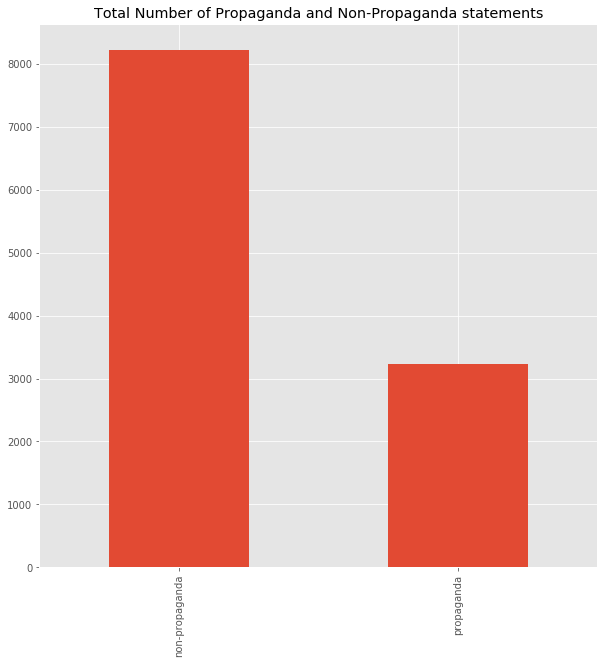

In [3]:
_ = df['label'].value_counts().plot.bar(figsize=(10, 10))
plt.title('Total Number of Propaganda and Non-Propaganda statements');

From the above plot we can clearly see that the number of non-propaganda statements are higher than the number of propaganda statements.

Checking the number of unique articles present in the dataset

In [4]:
print('Total number of unique Article Titles\t', df['article_title'].value_counts().shape[0])
print("Total number of unique Article ID's\t", df['article_id'].value_counts().shape[0])
df['article_title'].value_counts().reset_index().head()

Total number of unique Article Titles	 230
Total number of unique Article ID's	 233


,index,article_title
0,FOR THE FIRST TIME ONLINE: Archbishop Lefebvre...,428
1,"Archbishop Viganò Speaks, the Neo-Catholics Panic",231
2,A Dismal Record: Why Are They Destroying the N...,222
3,Pope Francis vs Contemplative Orders,207
4,"SPECIAL REPORT: Papal Cover-up Alleged, Pope A...",189


We can see that there are 230 unique article titles and 233 article id's. We are going to perform our next analysis using th e article id's.

Checking the number of propaganda and non-propaganda articles present in each article type and f there are any specific article id where only nay one type of article is present.

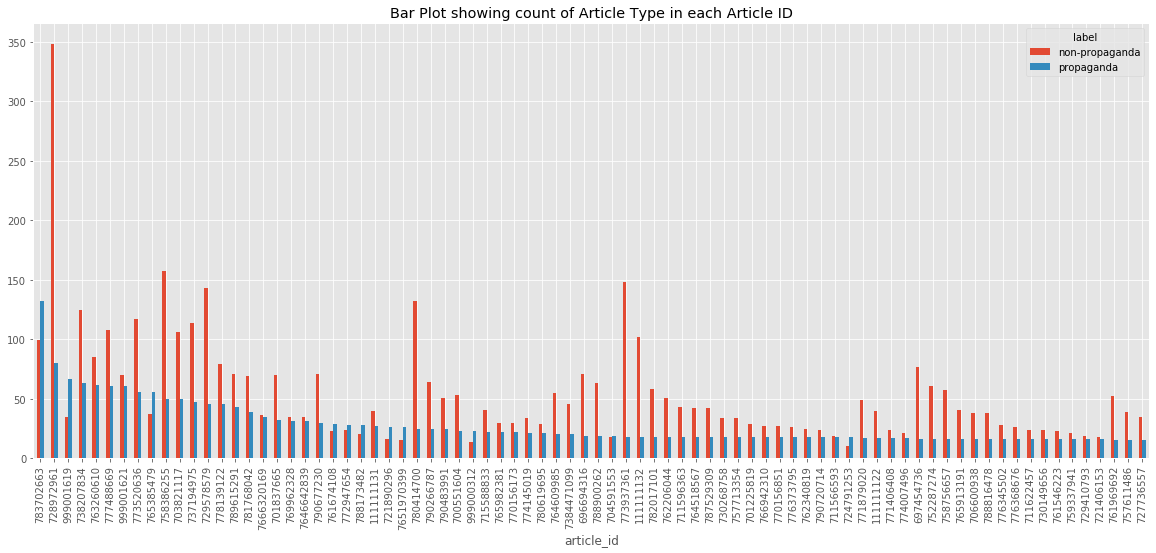

In [5]:
z = df.groupby('article_id')['label'].value_counts().unstack()
_ = z.sort_values(['propaganda', 'non-propaganda'], ascending=[False, False]).iloc[:80].plot.bar(figsize=(20, 8))
plt.title('Bar Plot showing count of Article Type in each Article ID');

From the above plot we can not only understand that the dataset is imbalanced, but also the every article id has a contribution to the imbalance.

<a id="3"></a>
## **3. Cleaning**

<a id="3a"></a>
### **i. Removing Punctuatoins**
We are going to perform a very basic cleaning process where we extract the text from the scentences and the article titles.


In [6]:
import re

def word_extract(text):
    text = re.sub(r'(-)|(,)|(\.)', '',text)
    text = re.findall(r'[A-Za-z\d]+[\w^\']*', text.lower())
    text = [i.strip() for i in text]
    return ' '.join(text)

for i, r in df.tail().iterrows():
    print('\nBefore........')
    print(r['article_title'])
    print(r['sentence_text'])
    print('-'*50)
    print('After...........')
    print(word_extract(r['article_title']))
    print(word_extract(r['sentence_text']))
    print('*'*80)    


Before........
Et Tu, Benedict?
Maike Hickson quotes him, writing of this bizarre situation – in which each, of the so-called “Sankt Gallen Mafia” prelates, including Kasper, who openly campaigned for the effective abolition of Catholic moral teaching: “It was characteristic of the church’s effective truce [between conservatives and progressivists] that John Paul II himself had given most of them their red hats, elevating them despite their disagreement with his restorationist approach.”
--------------------------------------------------
After...........
et tu benedict
maike hickson quotes him writing of this bizarre situation in which each of the socalled sankt gallen mafia prelates including kasper who openly campaigned for the effective abolition of catholic moral teaching it was characteristic of the church s effective truce between conservatives and progressivists that john paul ii himself had given most of them their red hats elevating them despite their disagreement with his re

From the above section we can see how the text is being cleaned of punctuations. Regex is being used here to extract the texts.  
The scentence text and the article titles are joined together to form a new column and the corresponding seq length is checked.

<a id="3b"></a>
### **ii. Sequence Analysis**

In [7]:
df['joined_text'] = df['article_title'] + ' ' + df['sentence_text']
df['joined_text'] = df['joined_text'].apply(word_extract)
df['seq_length'] = df['joined_text'].apply(lambda x: len(x.split()))
df_ = df[['joined_text', 'label', 'seq_length']]
df_.head()

,joined_text,label,seq_length
8756,major new study homeschooling spikes due to sc...,non-propaganda,24
1756,chile coverup' letter contradicts pope in that...,propaganda,34
7904,mueller is looking for trouble trump says cryp...,non-propaganda,47
174,coroner defies court order won't release las v...,propaganda,17
5604,et tu benedict don t we all want to know why h...,non-propaganda,17


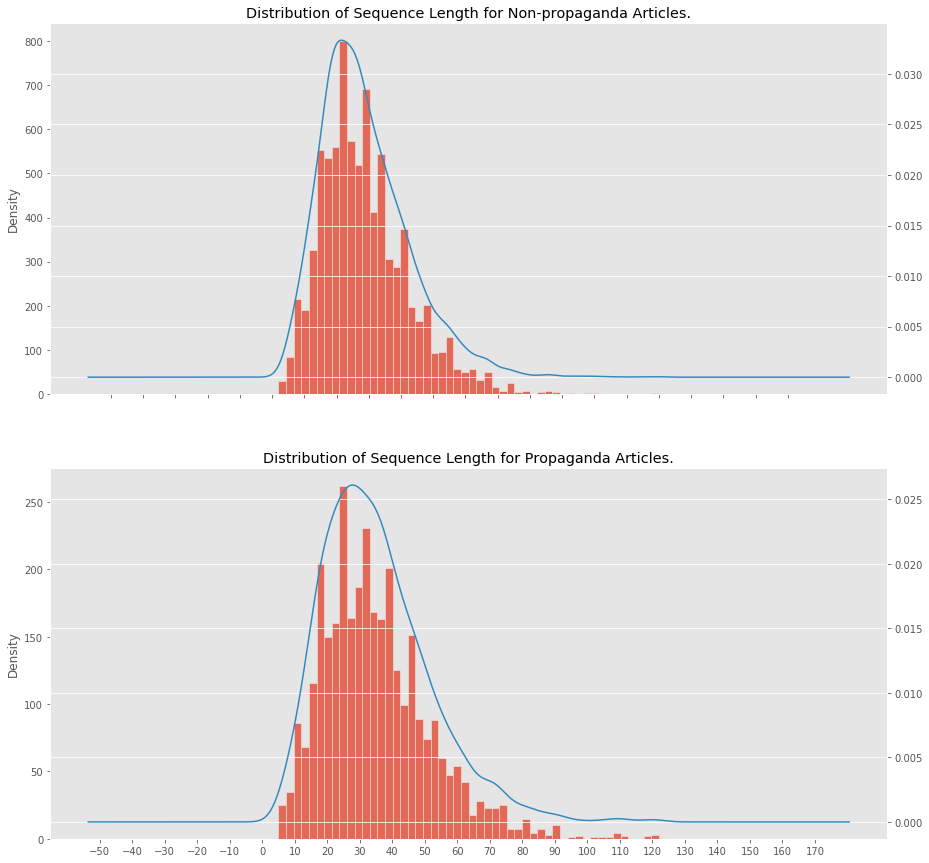

In [8]:
plt.subplot(2, 1, 1)
p1 = df_[df_['label']=='non-propaganda']['seq_length'].plot.hist(bins=50, figsize=(15, 15), edgecolor='w', alpha=0.8);
p1.set_xticks(range(-50, df_[df_['label']=='non-propaganda']['seq_length'].max()+50, 10))
p0 = df_[df_['label']=='non-propaganda']['seq_length'].plot.kde(secondary_y=True);
plt.title('Distribution of Sequence Length for Non-propaganda Articles.');
plt.subplot(2, 1, 2)
p1 = df_[df_['label']=='propaganda']['seq_length'].plot.hist(bins=50, figsize=(15, 15), edgecolor='w', alpha=0.8);
p1.set_xticks(range(-50, df_[df_['label']=='propaganda']['seq_length'].max()+50, 10))
p0 = df_[df_['label']=='propaganda']['seq_length'].plot.kde(secondary_y=True);
plt.title('Distribution of Sequence Length for Propaganda Articles.');

From the above distributions we can see that for both propaganda and non-propaganda based articles most of the sequences lie in between 20 to 50 range.

Checking the number of articles having sequnce length less than or equal to 10.

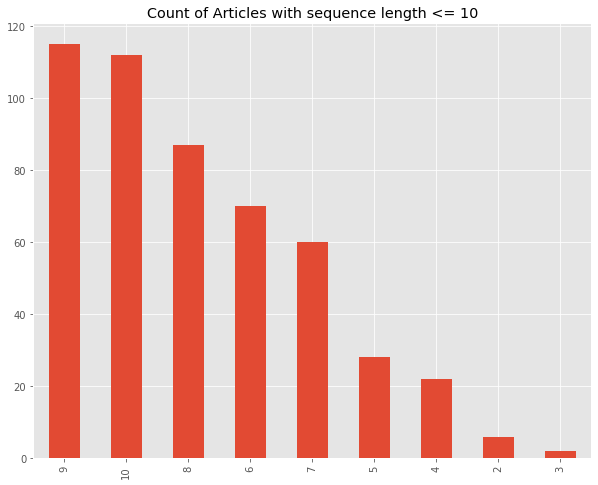

In [9]:
df_[df_['seq_length'] < 11]['seq_length'].value_counts().plot.bar(figsize=(10, 8));
plt.title('Count of Articles with sequence length <= 10');

Now we're going to build our corpus and create numerical representation of a sequence.  
For this we need to map every word in our corpus to an id and the sam id to a word.

In [10]:
corpus = df_['joined_text'].to_list()
corpus = ' '.join(corpus).split()

corpus = Counter(corpus)
corpus = sorted(corpus, key=corpus.get, reverse=True)
word_to_id = {word:i for i, word in enumerate(corpus, start=1)}
id_to_word = {i:word for word, i in word_to_id.items()}
joined_text_int = []
for t in df_['joined_text'].to_list():
    joined_text_int.append([word_to_id[word] for word in t.split()])

In [11]:
assert(df_['joined_text'].iloc[0] == ' '.join([id_to_word[i] for i in joined_text_int[0]]))

In [12]:
df_['joined_text_int'] = joined_text_int

In [13]:
seq_lengths = df_['joined_text_int'].apply(lambda x: len(x))

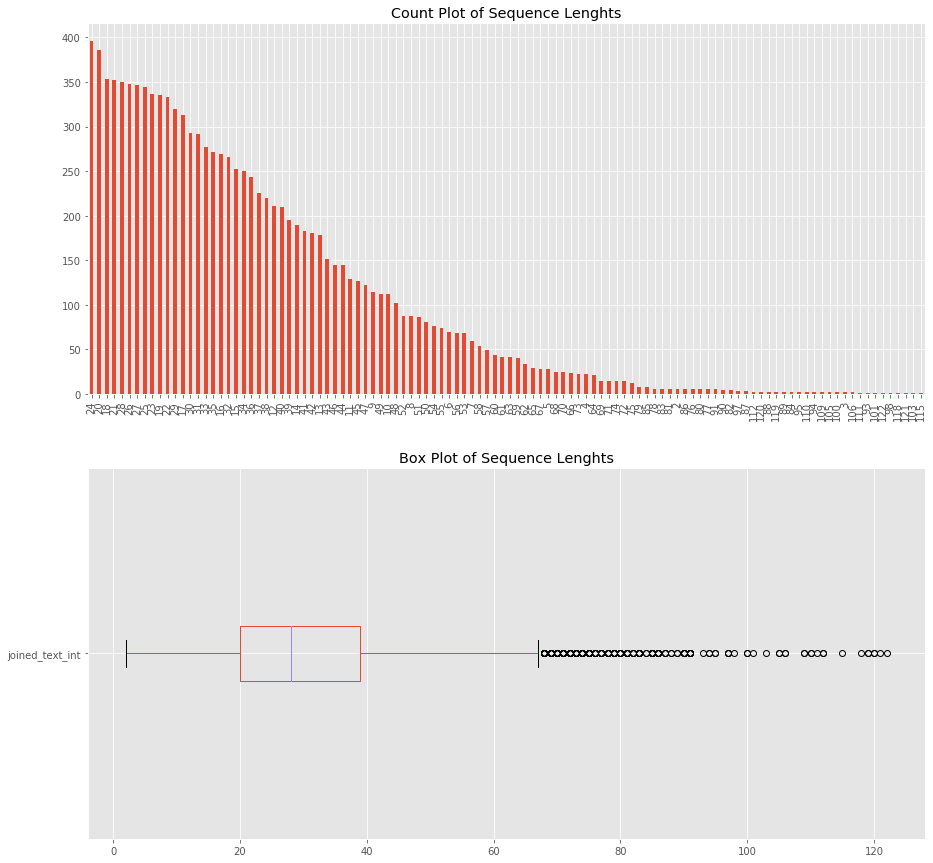

In [14]:
plt.subplot(2, 1, 1)
seq_lengths.value_counts().plot.bar(figsize=(15, 15));
plt.title('Count Plot of Sequence Lenghts');
plt.subplot(2, 1, 2)
seq_lengths.plot.box(figsize=(15, 15), vert=False);
plt.title('Box Plot of Sequence Lenghts');

Checking articles with sequence length of size 2.

In [15]:
df.loc[seq_lengths[seq_lengths == 2].index]

,article_id,article_title,label,sentence_text,joined_text,seq_length
2890,694327499,Wait!,non-propaganda,Me.,wait me,2
2891,694327499,Wait!,non-propaganda,A.,wait a,2
2862,694327499,Wait!,non-propaganda,Wait!,wait wait,2
2889,694327499,Wait!,non-propaganda,Give.,wait give,2
2861,694327499,Wait!,non-propaganda,Wait!,wait wait,2
2892,694327499,Wait!,non-propaganda,Break.,wait break,2


Checking articles with sequence length of size 3.

In [16]:
df.loc[seq_lengths[seq_lengths == 3].index]

,article_id,article_title,label,sentence_text,joined_text,seq_length
2872,694327499,Wait!,non-propaganda,Dawn Goldstein,wait dawn goldstein,3
2880,694327499,Wait!,non-propaganda,Big difference.,wait big difference,3


We can see there are certain scentence text which have only one word and their corresponding articles are also having similar format.  
We are not going to remove these rows as there exists lot of imbalance in the data.  
Each joined text is hoing to be padded with zeroes to have the same length as all the other sequences. 
All the scentences are going to be made of the same length as the maximum sequence length available in the dataset.

In [17]:
def pad_features(data_series, seq_length):

    padded_features = np.zeros((len(data_series.values), seq_length), dtype=int)
    for i, v in enumerate(data_series):
        padded_features[i, -len(v):] = np.array(v)[:seq_length]
    return list(padded_features)

In [18]:
df_['joined_text_padded'] = pad_features(df_['joined_text_int'], seq_lengths.max())

assert len(df_['joined_text_padded'][0])==seq_lengths.max()

df_['label'] = df_['label'].apply(lambda x: 1 if x == 'propaganda' else 0)

df_.head()

,joined_text,label,seq_length,joined_text_int,joined_text_padded
8756,major new study homeschooling spikes due to sc...,0,24,"[870, 68, 871, 489, 1728, 609, 2, 128, 309, 16...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1756,chile coverup' letter contradicts pope in that...,1,34,"[426, 1194, 242, 1116, 32, 4, 7, 242, 937, 190...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7904,mueller is looking for trouble trump says cryp...,0,47,"[310, 10, 1056, 8, 1617, 15, 157, 1955, 310, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
174,coroner defies court order won't release las v...,1,17,"[1457, 1699, 211, 224, 807, 490, 63, 52, 1730,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5604,et tu benedict don t we all want to know why h...,0,17,"[243, 253, 186, 425, 60, 29, 43, 214, 2, 222, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<a id="4"></a>
### **Data Split & Vectorizer**

<a id="4a"></a>
### **i. Train-Dev-Test Split**

We're going to split the data into 3 sets.  
 - Train Set 60%  
 - Dev Set 20%  
 - Test Set 20%  
   
As the data is imbalance we need to make sure the distribution of the data is similar in all the splits.

In [19]:
df_joined_padded_text = df_[['joined_text','joined_text_padded']]
df_label = df_['label'].to_list()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_joined_padded_text, df_label, test_size=0.4, random_state=518123)

print('Training set size\t {}'.format(len(X_train)))
print('Remaining set size\t {}'.format(len(X_test)))

Training set size	 6878
Remaining set size	 4586


In [20]:
X_dev, X_ho, y_dev, y_ho = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('Dev set size\t {}'.format(len(X_dev)))
print('Test set size\t {}'.format(len(X_ho)))

Dev set size	 2293
Test set size	 2293


Checking the distribution of labels in each split.

In [21]:
train_ratio = pd.Series(y_train).value_counts()
train_ratio = train_ratio*100/train_ratio.sum()
print('Train Labels Distribution %\n', train_ratio.to_dict(), '\n')
test_ratio = pd.Series(y_dev).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Dev Labels Distribution %\n', test_ratio.to_dict(), '\n')

test_ratio = pd.Series(y_dev).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Hold Out Labels Distribution %\n', test_ratio.to_dict(), '\n')

Train Labels Distribution %
 {0: 71.70689153823785, 1: 28.29310846176214} 

Dev Labels Distribution %
 {0: 70.91146969036197, 1: 29.088530309638028} 

Hold Out Labels Distribution %
 {0: 70.91146969036197, 1: 29.088530309638028} 



The data distribution in all the sets are similar. Hence, we can proceed with further modelling.

In [22]:
train_ratio = pd.Series(y_train).value_counts()
# train_ratio.to_dict()

As the data is imbalanced, we need to use class weightage for imbalanced data.  
The class weightage is calculated according to the formulae given [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).  
The formulae is shown below:

- $\frac{1}{label count} * \frac{sum of  label counts}{2}$

In [23]:
weight_for_non_propaganda = (1 / train_ratio[1])*(train_ratio[0]+train_ratio[1])/2.0 
weight_for_propaganda = (1 / train_ratio[0])*(train_ratio[0]+train_ratio[1])/2.0

print('Class weight for propaganda\t {}'.format(weight_for_propaganda))
print('Class weight for non-propaganda\t {}'.format(weight_for_non_propaganda))

Class weight for propaganda	 0.6972830494728305
Class weight for non-propaganda	 1.7672147995889003


<a id="4b"></a>
### **ii. Tf-Idf Vectorizer**

Here, we are going to use the classical Tf-Idf vectorizer and along with **Logistic Regression.**

In [24]:
train_text = X_train['joined_text'].to_list()
train_labels = y_train
max_feature_num = 350000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 4), min_df=5, max_df=0.8*80000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [25]:
clf = LogisticRegression(C = 15.75, max_iter=250, n_jobs=10, solver='sag', penalty='l2',
                         class_weight={0:weight_for_non_propaganda, 1:weight_for_propaganda})
clf.fit(train_vecs, train_labels)

LogisticRegression(C=15.75,
                   class_weight={0: 1.7672147995889003, 1: 0.6972830494728305},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=250, multi_class='auto', n_jobs=10,
                   penalty='l2', random_state=None, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

On the dev set we can see that it is having a f1-score of **0.58** and on the hold out set it's f1-score is **0.62**.

In [26]:
test_text = X_dev['joined_text'].to_list()
test_labels = y_dev
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='macro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.7357174007849978
precision 0.6826795921066164
rec 0.5917078361188409
f1 0.5932683526519142


In [27]:
test_text = X_ho['joined_text'].to_list()
test_labels = y_ho
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='macro')
print('Result on Hold_out-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Hold_out-Test set
-----------------------
acc 0.7518534670737026
precision 0.6894527667976478
rec 0.5932372563027146
f1 0.598193170881934


<a id="4c"></a>
### **iii. Word-to-Vec**

Next we are going to try pre-trained word embeddings from **GloVe** and check the performance on both ***Logistic Regression*** and ***Neural Netowrk Based models.***

In [28]:
# load the glove pre-trained embedding
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

path_of_downloaded_files = "/home/archie/Documents/RHUL/Term_02/CS5990-NLP/Labs/glove/glove.6B.300d.txt"
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [29]:
from nltk.tokenize import word_tokenize
import numpy as np

# Out-of-vocabulary (OOV) words: words that are not included in the pre-trained embedding model
# There exist many ways to vectorize OOV words, e.g. use a random vector to represent all OOV words
# Feel free to search and employ other ways to vectorize OOV words
word_vec_dim = 300 # make sure this number matches the embedding you use
oov_vec = np.random.rand(word_vec_dim) 
def vectorize_sent(word_vectors, sent):
    word_vecs = []
    for token in word_tokenize(sent): 
        if token not in word_vectors: 
            word_vecs.append(oov_vec)
        else:
            word_vecs.append(word_vectors[token].astype('float64'))
    return np.mean(word_vecs,axis=0)

vv = vectorize_sent(word_vectors, 'hello world ! this is a test sentence !')

In [44]:
# create vector representations; 
# TODO: consider to apply necessary text cleaning/normalization techniques
# TODO: consider whether to use titles information (the example below does not use titles but only sentences)
train_docs = X_train['joined_text'].to_list()
dev_docs = X_dev['joined_text'].to_list()
test_docs = X_ho['joined_text'].to_list()
train_labels = y_train
dev_labels = y_dev
test_labels = y_ho
train_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in train_docs])
dev_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in dev_docs])
test_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_docs])
# print(train_vecs.shape)
label_dic = {'non-propaganda':0, 'propaganda':1}

In [45]:
clf = LogisticRegression(C = 15.75, max_iter=250, n_jobs=10, solver='sag', penalty='l2',
                         class_weight={0:weight_for_non_propaganda, 1:weight_for_propaganda})
clf.fit(train_vecs, train_labels)

LogisticRegression(C=15.75,
                   class_weight={0: 1.7672147995889003, 1: 0.6972830494728305},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=250, multi_class='auto', n_jobs=10,
                   penalty='l2', random_state=None, solver='sag', tol=0.0001,
                   verbose=0, warm_start=False)

On the dev set we can see that it is having a f1-score of **0.46** and on the hold out set it's f1-score is **0.44**.

In [46]:
preds = clf.predict(dev_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='macro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.7104230266027038
precision 0.4742358297063385
rec 0.4960439999385476
f1 0.43764146204532706


In [47]:
preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='macro')
print('Result on Hold_out-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Hold_out-Test set
-----------------------
acc 0.7313563017880506
precision 0.6413438555597257
rec 0.5274817179026287
f1 0.4902458389271433


Next we are going to check a few Neural Network Architechtures and their performance.

<a id="5"></a>
## **5. Neural Network Architectures**

> Hyper Parameters: There are several hyper-parameters when it comes to neural networks.  
Learning rate, number of epochs and Batch size are the 2 most important among them.   
Keeping the time and computational memory complexity in mind, for this coursework we are going to follow the below specificaitons for all the neural network training methods:
- **Batch Size** - ***64***
- **Learning Rate** - Starting with ***0.001*** followed by decay by a factor of ***0.95 every 2 epochs.***
- **Epochs** - ***20***

<a id="5a"></a>
### **i. Simple DNN Architecture**

First we are going to look into a simple DNN Architecture.  
The network architecture is shown below:

In [39]:
# define a simple MLP (multi-layer perceptron) as the classifation model
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, out_dim, dp_rate):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_dim, input_dim*2)
        self.output_layer = nn.Linear(input_dim*2, out_dim)
        self.dropout = nn.Dropout(dp_rate)
        self.relu = torch.nn.ReLU()
        if torch.cuda.is_available():
            self.to('cuda')
       
    def forward(self, x_in):
        z1 = self.dropout(x_in) # output of the input layer, after dropout
        z2 = self.relu(self.hidden(z1)) # output of the hidden layer
        logits = self.output_layer(z2)
        return logits


# build model
dropout_rate = 0.5 
model = MLP(word_vec_dim,len(label_dic),dropout_rate) 

loss_fnc = torch.nn.CrossEntropyLoss()

# hyper parameters
n_epochs = 20 # number of epoch (i.e. number of iterations)
batch_size = 32 # mini batch size
lr = 0.001 # initial learning rate

# initialize optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) 
# decays the learning rate of each parameter group by gamma every step_size epochs.

print(model)

MLP(
  (hidden): Linear(in_features=300, out_features=600, bias=True)
  (output_layer): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [40]:
# define a simple MLP (multi-layer perceptron) as the classifation model
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, out_dim, dp_rate):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_dim, input_dim*2)
        self.output_layer = nn.Linear(input_dim*2, out_dim)
        self.dropout = nn.Dropout(dp_rate)
        self.relu = torch.nn.ReLU()
        if torch.cuda.is_available():
            self.to('cuda')
       
    def forward(self, x_in):
        z1 = self.dropout(x_in) # output of the input layer, after dropout
        z2 = self.relu(self.hidden(z1)) # output of the hidden layer
        logits = self.output_layer(z2)
        return logits


# build model
dropout_rate = 0.5 
model = MLP(word_vec_dim,len(label_dic),dropout_rate) 

loss_fnc = torch.nn.CrossEntropyLoss()

# hyper parameters
n_epochs = 20 # number of epoch (i.e. number of iterations)
batch_size = 32 # mini batch size
lr = 0.001 # initial learning rate

# initialize optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) 
# decays the learning rate of each parameter group by gamma every step_size epochs.

print(model)

MLP(
  (hidden): Linear(in_features=300, out_features=600, bias=True)
  (output_layer): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


In [41]:
best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

learning_rates=[]
fi_scores=[]
for epoch_i in range(n_epochs):
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
#     hidden = model.init_hidden(batch_size)
    for idx in range(0,len(train_vecs),batch_size):
        # Step 0: Get the data
        x_data = torch.tensor(train_vecs[idx:idx+batch_size], dtype=torch.float)
        if x_data.shape[0] == 0: continue
        y_target = torch.tensor(train_labels[idx:idx+batch_size], dtype=torch.int64)
        
        if torch.cuda.is_available():
            x_data, y_target = x_data.to('cuda'), y_target.to('cuda')

        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred= model(x_data)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)

        # Step 4: Propagate the loss signal backward
        loss.backward()

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        dev_data = torch.tensor(dev_vecs, dtype=torch.float)
        dev_target = torch.tensor(dev_labels, dtype=torch.int64)
        if torch.cuda.is_available():
            dev_data, dev_target = dev_data.to('cuda'), dev_target.to('cuda')
        dev_prediction = model(dev_data)
        pred_labels = [np.argmax(dp.numpy()) for dp in dev_prediction.cpu()]
        pre, rec, f1, _ = precision_recall_fscore_support(dev_target.cpu(), pred_labels, average='macro')
        print('\n---> after epoch {} the macro-f1 on dev set is {}'.format(epoch_i+1, f1))
        fi_scores.append(f1)
        for param_group in optimizer.param_groups:
            learning_rates.append(param_group['lr'])
#             print('learning rate', param_group['lr'])
        
        # save the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
#             print('best model updated; new best f1',f1)
            
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()
    


---> after epoch 1 the macro-f1 on dev set is 0.5069345750860785

---> after epoch 2 the macro-f1 on dev set is 0.5971064074834836

---> after epoch 3 the macro-f1 on dev set is 0.556017117601665

---> after epoch 4 the macro-f1 on dev set is 0.5900522210580585

---> after epoch 5 the macro-f1 on dev set is 0.6029880389724306

---> after epoch 6 the macro-f1 on dev set is 0.6163570041811062

---> after epoch 7 the macro-f1 on dev set is 0.619812544498737

---> after epoch 8 the macro-f1 on dev set is 0.6127022226649663

---> after epoch 9 the macro-f1 on dev set is 0.6395384414115581

---> after epoch 10 the macro-f1 on dev set is 0.62707365393634

---> after epoch 11 the macro-f1 on dev set is 0.612615894663371

---> after epoch 12 the macro-f1 on dev set is 0.6311675974749028

---> after epoch 13 the macro-f1 on dev set is 0.6245916150274304

---> after epoch 14 the macro-f1 on dev set is 0.6245916150274304

---> after epoch 15 the macro-f1 on dev set is 0.6380426203630624

---> aft

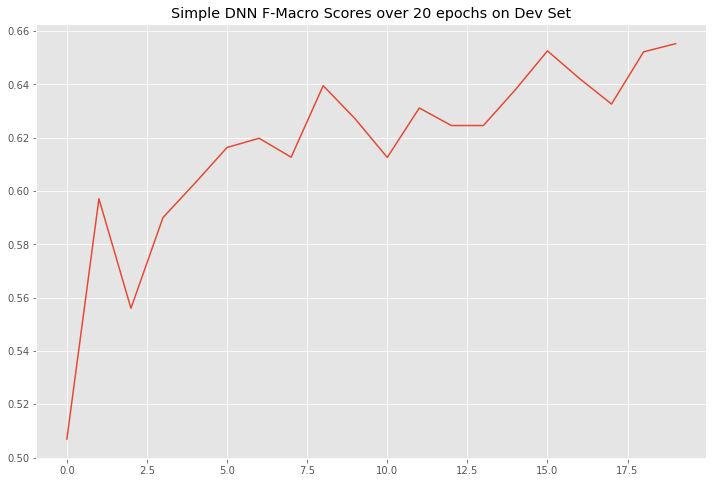

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(fi_scores)
plt.title('Simple DNN F-Macro Scores over 20 epochs on Dev Set');

From the above plot we can see that the F-1 Score on dev set.  
However, the performance on the hold-out test set is poor.
It's obtaining a test-score of just **0.49.**

In [48]:
# test on the test set

# load the best model weights
model.load_state_dict(best_model) 
test_docs = X_ho['joined_text'].to_list()
test_vecs = np.array([vectorize_sent(word_vectors, ss) for ss in test_docs])
test_labels = y_ho

with torch.no_grad(): 
    model.eval()
    test_data = torch.tensor(test_vecs, dtype=torch.float)
    test_target = torch.tensor(test_labels, dtype=torch.int64)
    if torch.cuda.is_available():
        test_data, test_target = test_data.to('cuda'), test_target.to('cuda')
    test_prediction = model(test_data)
    pred_labels = [np.argmax(dp.numpy()) for dp in test_prediction.cpu()]
    pre, rec, f1, _ = precision_recall_fscore_support(test_target.cpu(), pred_labels, average='macro')
    print('macro-f1 on test data', f1)

macro-f1 on test data 0.6660438164296116


<a id="5c"></a>
### **i. RNN (Recurrent Neural Network)**

<a id="5c1"></a>
#### **a. Basic RNN**

As this is a very imbalanced dataset, we'll keep the dropout value as **'0.2'**.

- Embedding Dimension - 300  
- Hidden Dimension - 300  
- RNN Layer Type - RNN
- Pooling Layer Type - Max
- Dropout - 0.2
___

In [51]:
# then we define the RNN-based classifier
import torch
import torch.nn as nn

class RNN_Classifier(nn.Module):
    def __init__(self, embd_dim, hidden_dim, model_type, cls_num, pooler_type, dropout, gpu):
        super(RNN_Classifier, self).__init__()
        assert model_type in ['rnn','lstm','bilstm','gru']
        assert pooler_type in ['max','avg']
        # rnn type
        if model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, bidirectional=True, dropout=dropout)
        else: # model_type == 'gru'
            self.rnn = nn.GRU(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        # map from rnn output to logits
        if model_type == 'linear':
            self.fc = nn.Linear(2*hidden_dim, cls_num)
        else:
            self.fc = nn.Linear(hidden_dim, cls_num)
        # pooler type
        self.pooler_type = pooler_type
        # gpu or not
        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def forward(self, input_matrix):
#         print('ip mat', input_matrix.shape)
        token_num = input_matrix.shape[1]
#         print('token_num', token_num)
        hidden_vecs = self.rnn(input_matrix)[0]
#         print('hidden', hidden_vecs.shape)
#         print(hidden_vecs)
        if self.pooler_type == 'max':
            pooler = nn.MaxPool1d(token_num)
            
        else: 
            pooler = nn.AvgPool1d(token_num)
            
        if self.gpu: pooler.to('cuda')
#         print('hidden_transpose', torch.transpose(hidden_vecs,1,2).squeeze().shape)
#         print(torch.transpose(hidden_vecs,1,2).squeeze())
        
        pooled_hidden = pooler(torch.transpose(hidden_vecs,1,2)).squeeze()
#         print('pooled', pooled_hidden.shape)
        fc = self.fc(pooled_hidden)
#         print('fc', fc.shape)
        return fc

# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 300
hidden_dim = 300
rnn_type = 'rnn'
pooler_type = 'avg'
dropout = 0.2
gpu = True

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    oov_vec = np.random.rand(embd_dim)
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
#     print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)

def make_batch_prediction(sent_list, word_vectors, model, use_gpu=False):
    batch = build_mini_batch(sent_list, word_vectors)
#     print(batch[0].shape)
    batch_logits = torch.tensor([])
    if use_gpu: batch_logits = batch_logits.to('cuda')
    for i in range(batch.shape[0]):
        input_sents = torch.from_numpy(batch[i]).float()
        if use_gpu:
            input_sents = input_sents.to('cuda')
#         print(input_sents.unsqueeze(0).shape)
        logits = model(input_sents.unsqueeze(0))
        batch_logits = torch.cat( (batch_logits, logits) )
    return batch_logits.view(batch.shape[0],-1)
  
# sanity check 
model = RNN_Classifier(embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, dropout, gpu)
print(model)
batch_pred = make_batch_prediction(
    ['hello world!','hello','another test sentence this is'],
    word_vectors, model, gpu)
# print(batch_pred)

RNN_Classifier(
  (rnn): RNN(300, 300, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=300, out_features=2, bias=True)
)


In [52]:
loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss

# hyper parameters
n_epochs = 20 # number of epoch (i.e. number of iterations)
batch_size = 50
lr = 0.001 # initial learning rate

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999) 
# after each epoch, the learning rate is discounted to its 95%
# print(model)

In [ ]:
# training the CNN model

best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm, notebook

rnn_learning_rates = []
rnn_f1_sores = []

for epoch_i in range(n_epochs):
    print('epoch {}/{}'.format(epoch_i, n_epochs))
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    for idx in notebook.tqdm(range(0,len(train_docs),batch_size)):
        # Step 0: Get the data
        sents = train_docs[idx:idx+batch_size]
        if len(sents) == 0: break
        y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = make_batch_prediction(sents, word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()
        
        # Step 4+: clip the gradient, to avoid gradient explosion
        nn.utils.clip_grad_value_(model.parameters(), clip_value=3.)

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        predictions = []
        test_docs = dev_docs
        test_labels = dev_labels
        
        for idx in range(0,len(dev_docs),batch_size):
            y_pred = make_batch_prediction(dev_docs[idx:idx+batch_size], word_vectors, model, gpu)
            pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
            predictions += pred_labels
        pre, rec, f1, _ = precision_recall_fscore_support(dev_labels, predictions,average='macro')
        rnn_f1_sores.append(f1)
#         print('\n---> after epoch {} the macro-F1 on dev set is {}'.format(epoch_i, f1))
        for param_group in optimizer.param_groups:
            learning_rates.append(param_group['lr'])
#             print('learning rate', param_group['lr'])
        
        # save the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            print('best model updated; new best macro-F1',f1)
    
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()

>The same code snippet is used to generate the following plots after training.  
The **model** parameters of the RNN_Classifier is changed keeping all the remaining parameters same to generate RNN Classification models with different RNN units.

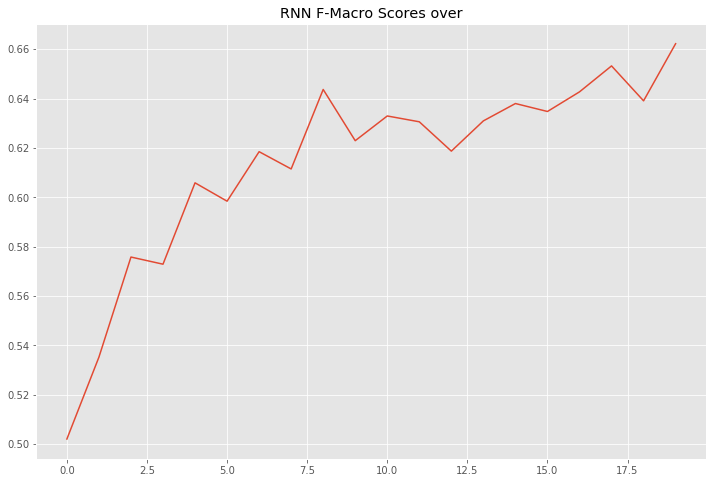

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(rnn_f1_sores)
plt.title('RNN F-Macro Scores over');

>We can see that the performance increases with each epoch and tends to become static around **0.65.**

In [56]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 
test_docs = X_ho['joined_text'].to_list()
test_labels = y_ho

with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    predictions = []
#     test_docs = test_docs
#     test_labels = dev_labels

    for idx in range(0,len(test_docs),batch_size):
        y_pred = make_batch_prediction(
            test_docs[idx:idx+batch_size], word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        predictions += pred_labels
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, predictions,average='macro')
    print('The macro-F1 on Test set is {}'.format(f1))

The macro-F1 on Test set is 0.6766190462381398


<a id="5c2"></a>
#### **b. LSTM**

- Embedding Dimension - 300  
- Hidden Dimension - 300  
- RNN Layer Type - LSTM
- Pooling Layer Type - Max
- Dropout - 0.2
___

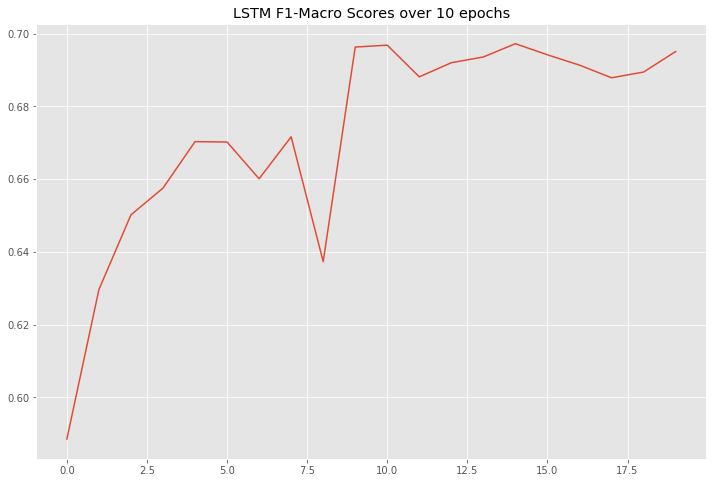

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(rnn_f1_sores)
plt.title('LSTM F1-Macro Scores over 10 epochs');

>We can see that the performance increases with each epoch and tends to become static around **0.70.**

In [17]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 

with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    predictions = []
#     test_docs = test_docs
#     test_labels = dev_labels

    for idx in range(0,len(test_docs),batch_size):
        y_pred = make_batch_prediction(
            test_docs[idx:idx+batch_size], word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        predictions += pred_labels
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, predictions,average='macro')
    print('The macro-F1 on Test set is {}'.format(f1))

The macro-F1 on Test set is 0.6983682022053179


<a id="5c3"></a>
#### **c. Bi-LSTM**

Bi-LSTM models have 2 sets of sequence checks. Once forward and second is backward.  
Hence, the next layer should be double the number of hidden layer output from LSTM layer.
- Embedding Dimension - 300  
- Hidden Dimension - 300  
- Fully Connected Layer - 600
- RNN Layer Type - LSTM (Bi-Directional True)
- Pooling Layer Type - Average
- Dropout - 0.2
___

In [57]:
# then we define the RNN-based classifier
import torch
import torch.nn as nn

class RNN_Classifier(nn.Module):
    def __init__(self, embd_dim, hidden_dim, model_type, cls_num, pooler_type, dropout, gpu):
        super(RNN_Classifier, self).__init__()
        assert model_type in ['rnn','lstm','bilstm','gru']
        assert pooler_type in ['max','avg']
        # rnn type
        if model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, bidirectional=True, dropout=dropout)
        else: # model_type == 'gru'
            self.rnn = nn.GRU(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        # map from rnn output to logits
        if model_type == 'bilstm':
            self.fc = nn.Linear(2*hidden_dim, cls_num)
        else:
            self.fc = nn.Linear(hidden_dim, cls_num)
        # pooler type
        self.pooler_type = pooler_type
        # gpu or not
        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def forward(self, input_matrix):
#         print('ip mat', input_matrix.shape)
        token_num = input_matrix.shape[1]
#         print('token_num', token_num)
        hidden_vecs = self.rnn(input_matrix)[0]
#         print('hidden', hidden_vecs.shape)
#         print(hidden_vecs)
        if self.pooler_type == 'max':
            pooler = nn.MaxPool1d(token_num)
            
        else: 
            pooler = nn.AvgPool1d(token_num)
            
        if self.gpu: pooler.to('cuda')
#         print('hidden_transpose', torch.transpose(hidden_vecs,1,2).squeeze().shape)
#         print(torch.transpose(hidden_vecs,1,2).squeeze())
        
        pooled_hidden = pooler(torch.transpose(hidden_vecs,1,2)).squeeze()
#         print('pooled', pooled_hidden.shape)
        fc = self.fc(pooled_hidden)
#         print('fc', fc.shape)
        return fc

# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 300
hidden_dim = 300
rnn_type = 'bilstm'
pooler_type = 'avg'
dropout = 0.2
gpu = True

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    oov_vec = np.random.rand(embd_dim)
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
#     print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)

def make_batch_prediction(sent_list, word_vectors, model, use_gpu=False):
    batch = build_mini_batch(sent_list, word_vectors)
#     print(batch[0].shape)
    batch_logits = torch.tensor([])
    if use_gpu: batch_logits = batch_logits.to('cuda')
    for i in range(batch.shape[0]):
        input_sents = torch.from_numpy(batch[i]).float()
        if use_gpu:
            input_sents = input_sents.to('cuda')
#         print(input_sents.unsqueeze(0).shape)
        logits = model(input_sents.unsqueeze(0))
        batch_logits = torch.cat( (batch_logits, logits) )
    return batch_logits.view(batch.shape[0],-1)
  
# sanity check 
model = RNN_Classifier(embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, dropout, gpu)
print(model)
batch_pred = make_batch_prediction(
    ['hello world!','hello','another test sentence this is'],
    word_vectors, model, gpu)
# print(batch_pred)

RNN_Classifier(
  (rnn): LSTM(300, 300, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
)


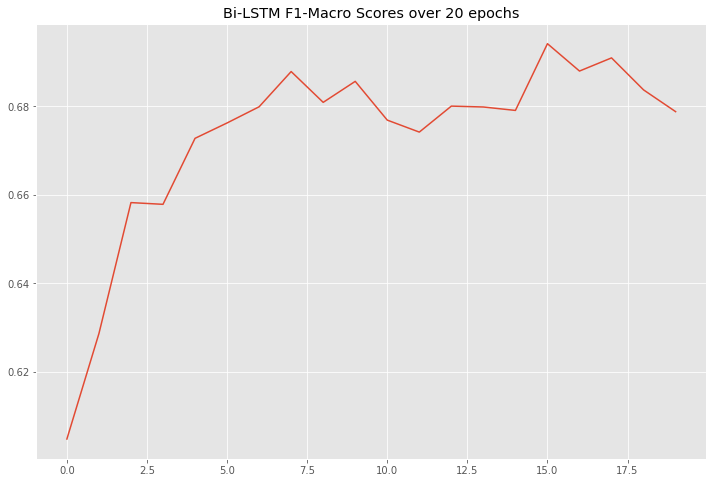

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(rnn_f1_sores)
plt.title('Bi-LSTM F1-Macro Scores over 20 epochs');

>It's clearly noticeable that there's not static increase in performance. The last checkpoint saved at **0.7**, also ***co-incidentally produces similar results in the test set, but this result cannot be relied on.***  
This is a clear indication of over-fitting.

In [13]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 

with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    predictions = []
#     test_docs = test_docs
#     test_labels = dev_labels

    for idx in range(0,len(test_docs),batch_size):
        y_pred = make_batch_prediction(
            test_docs[idx:idx+batch_size], word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        predictions += pred_labels
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, predictions,average='macro')
    print('The macro-F1 on Test set is {}'.format(f1))

The macro-F1 on Test set is 0.6934018679575762


<a id="5c4"></a>
#### **d. Bi-GRU**

Similar to Bi-LSTM, Bidirectional GRU models have 2 sets of sequence checks. Once forward and second is backward.  
Hence, the next layer should be double the number of hidden layer output from LSTM layer.
- Embedding Dimension - 300  
- Hidden Dimension - 300  
- Fully Connected Layer - 600
- RNN Layer Type - GRU ( Bi-Directional True)
- Pooling Layer Type - Average
- Dropout - 0.2
___

In [59]:
# then we define the RNN-based classifier
import torch
import torch.nn as nn

class RNN_Classifier(nn.Module):
    def __init__(self, embd_dim, hidden_dim, model_type, cls_num, pooler_type, dropout, gpu):
        super(RNN_Classifier, self).__init__()
        assert model_type in ['rnn','lstm','bilstm','gru-bi']
        assert pooler_type in ['max','avg']
        # rnn type
        if model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, bidirectional=True, dropout=dropout)
        elif model_type == 'gru-bi':
            self.rnn = nn.GRU(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout, bidirectional=True)
        # map from rnn output to logits
        if model_type == 'bilstm' or model_type == 'gru-bi':
            self.fc = nn.Linear(2*hidden_dim, cls_num)
        else:
            self.fc = nn.Linear(hidden_dim, cls_num)
        # pooler type
        self.pooler_type = pooler_type
        # gpu or not
        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def forward(self, input_matrix):
#         print('ip mat', input_matrix.shape)
        token_num = input_matrix.shape[1]
#         print('token_num', token_num)
        hidden_vecs = self.rnn(input_matrix)[0]
#         print('hidden', hidden_vecs.shape)
#         print(hidden_vecs)
        if self.pooler_type == 'max':
            pooler = nn.MaxPool1d(token_num)
            
        else: 
            pooler = nn.AvgPool1d(token_num)
            
        if self.gpu: pooler.to('cuda')
#         print('hidden_transpose', torch.transpose(hidden_vecs,1,2).squeeze().shape)
#         print(torch.transpose(hidden_vecs,1,2).squeeze())
        
        pooled_hidden = pooler(torch.transpose(hidden_vecs,1,2)).squeeze()
#         print('pooled', pooled_hidden.shape)
        fc = self.fc(pooled_hidden)
#         print('fc', fc.shape)
        return fc

# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 300
hidden_dim = 300
rnn_type = 'gru-bi'
pooler_type = 'avg'
dropout = 0.2
gpu = True

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    oov_vec = np.random.rand(embd_dim)
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
#     print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)

def make_batch_prediction(sent_list, word_vectors, model, use_gpu=False):
    batch = build_mini_batch(sent_list, word_vectors)
#     print(batch[0].shape)
    batch_logits = torch.tensor([])
    if use_gpu: batch_logits = batch_logits.to('cuda')
    for i in range(batch.shape[0]):
        input_sents = torch.from_numpy(batch[i]).float()
        if use_gpu:
            input_sents = input_sents.to('cuda')
#         print(input_sents.unsqueeze(0).shape)
        logits = model(input_sents.unsqueeze(0))
        batch_logits = torch.cat( (batch_logits, logits) )
    return batch_logits.view(batch.shape[0],-1)
  
# sanity check 
model = RNN_Classifier(embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, dropout, gpu)
print(model)
batch_pred = make_batch_prediction(
    ['hello world!','hello','another test sentence this is'],
    word_vectors, model, gpu)
# print(batch_pred)

RNN_Classifier(
  (rnn): GRU(300, 300, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
)


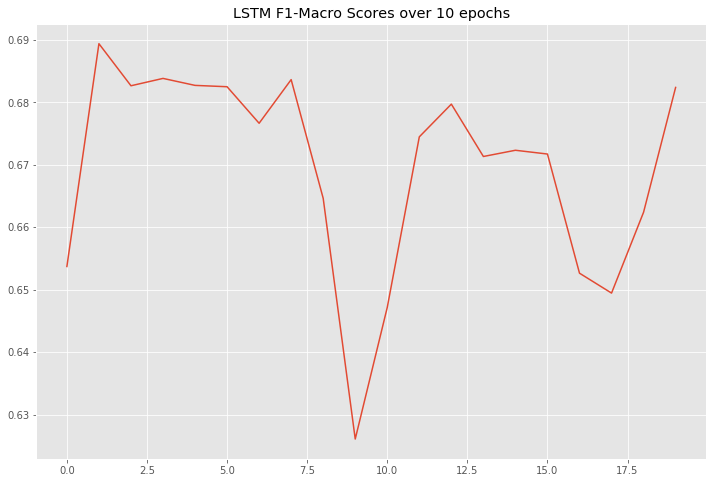

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(rnn_f1_sores)
plt.title('LSTM F1-Macro Scores over 10 epochs');

>**Plot Title: Bi-GRU F1-Scores over 20 epochs**

>Ther performance is very similar to Bi-LSTM. The last checkpoint saved around **0.7**, also ***co-incidentally produces similar results in the test set, but this result cannot be relied on.***  
This is a clear indication of over-fitting.

In [13]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 

with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    predictions = []
#     test_docs = test_docs
#     test_labels = dev_labels

    for idx in range(0,len(test_docs),batch_size):
        y_pred = make_batch_prediction(
            test_docs[idx:idx+batch_size], word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        predictions += pred_labels
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, predictions,average='macro')
    print('The macro-F1 on Test set is {}'.format(f1))

The macro-F1 on Test set is 0.6905722198852613


<a id="5b"></a>
### **iii. CNN (Convolutional Neural Network**

Next we are going to look at Convolutional Neural Networks and it's performance on pre-trained word embeddings.  
Based on multiple combination of filters, the below architecture has shown the best performance.  
The network has simple structure as shown below.
- Word Embeddings of size 300 for each word are fed into the network
- 128 Convolutions of size 2
- 192 Convolutions of size 2
- 192 Convolutions of size 3
- 256 Convolutions of size 3
- 512 Convolutions of size 4
- Fully Connected Layer
---

In [46]:
# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

word_vec_dim = 300 # make sure this number matches the embedding you use

# Out-of-vocabulary (OOV) words: words that are not included in the pre-trained embedding model
# There exist many ways to vectorize OOV words, e.g. use a random vector to represent all OOV words
# Feel free to search and employ other ways to vectorize OOV words


def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    oov_vec = oov_vec = np.random.rand(word_vec_dim)
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*word_vec_dim)
    return np.array(np.transpose(vecs))

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
#     print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)
  
# sanity check 
# build_mini_batch(['hello world!','HELLO','this is a long sentence!'], word_vectors)

# define the CNN model

import numpy as np
import torch
import torch.nn as nn

class CNN_Clf(nn.Module):
    def __init__(self, embd_dim, filter_size_list, filter_num_list, class_num, dp_rate=0.5, gpu=True):
        super(CNN_Clf, self).__init__()
        self.embd_dim = embd_dim
        assert len(filter_size_list) == len(filter_num_list)
        self.output_dim = class_num
        
        self.convs = self.build_convs(filter_size_list, filter_num_list, gpu)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dp_rate)
        self.fc = nn.Linear(np.sum(filter_num_list), class_num)
        self.gpu = gpu
        
        if self.gpu:
            self.to('cuda')
            
    def build_convs(self, f_sizes, f_nums, gpu):
        convs = nn.ModuleList()
        for fs, fn in zip(f_sizes, f_nums):
            padding_size = fs-1
            m = nn.Conv1d(self.embd_dim, fn, fs, padding=padding_size)
            if gpu: m.to('cuda')
            convs.append(m)
        return convs
        
    def get_conv_output(self, input_matrix, conv, gpu):
        # step 1: compute convolution
#         print('input_matrix', input_matrix.shape)
        assert input_matrix.shape[1] == self.embd_dim
        if gpu:
            input_matrix = input_matrix.to('cuda')
        conv_output = conv(input_matrix)
        # step 2: pass through an activation function 
        conv_relu = self.tanh(conv_output)
        # step 3: max-over-time pooling
        maxp = nn.MaxPool1d(conv_relu.shape[2])
        maxp_output = maxp(conv_relu)
        return maxp_output
       
    def forward(self, all_text_vectors):
        cnn_repr = torch.tensor([])
        if self.gpu: cnn_repr = cnn_repr.to('cuda')
        for cv in self.convs:
            cv_output = self.get_conv_output(all_text_vectors, cv, self.gpu)
            cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        # print(cnn_repr.shape)
        after_dp = self.dropout(cnn_repr.squeeze())
        logit = self.fc(after_dp)
        # the CrossEntropyLoss provided by pytorch includes softmax; so you do not need to include a softmax layer in your net
        return logit

dropout_rate = 0.2# dropout rate
filter_sizes = [2, 2, 3, 3, 4]
filter_nums = [128, 192, 192, 256, 512]

gpu = True # whether use gpu to accelerate the training
model = CNN_Clf(word_vec_dim, filter_sizes, filter_nums, len(label_dic), dropout_rate, gpu=gpu)
loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss
print(model)
# hyper parameters
n_epochs = 50 # number of epoch (i.e. number of iterations)
batch_size = 32
lr = 0.001 # initial learning rate

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
# after each epoch, the learning rate is discounted to its 95%

CNN_Clf(
  (convs): ModuleList(
    (0): Conv1d(300, 128, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(300, 192, kernel_size=(2,), stride=(1,), padding=(1,))
    (2): Conv1d(300, 192, kernel_size=(3,), stride=(1,), padding=(2,))
    (3): Conv1d(300, 256, kernel_size=(3,), stride=(1,), padding=(2,))
    (4): Conv1d(300, 512, kernel_size=(4,), stride=(1,), padding=(3,))
  )
  (tanh): Tanh()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1280, out_features=2, bias=True)
)


In [47]:
# training the CNN model

best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm_gui, tqdm_notebook, tqdm, notebook

In [ ]:
cnn_f1_scores = []
for epoch_i in range(n_epochs):
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    for idx in notebook.tqdm(range(0,len(train_docs),batch_size)):
        # Step 0: Get the data
        x_data = build_mini_batch(train_docs[idx:idx+batch_size], word_vectors)
        if x_data.shape[0] == 0: continue # to avoid empty batch
        y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        x_tensor = torch.tensor(x_data, dtype=torch.float)
        if gpu:
            x_tensor = x_tensor.to('cuda')
        y_pred = model(x_tensor)
        if gpu: y_pred = y_pred.to('cuda')
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
#         print('pred labels', pred_labels)
#         print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
#         print('\n======batch {} ======'.format(idx))
    
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        print('Running on Dev Set..')
        dev_predictions = []
        for idx in notebook.tqdm(range(0,len(dev_docs),batch_size)):
            x_data = build_mini_batch(dev_docs[idx:idx+batch_size], word_vectors)
            if x_data.shape[0] == 0: continue # to avoid empty batch
            x_tensor = torch.tensor(x_data, dtype=torch.float)
#             print(x_tensor.shape)
            if gpu:
                x_tensor = x_tensor.to('cuda')
            y_pred = model(x_tensor)#.cpu().detach().numpy()
            if gpu: y_pred = y_pred.to('cuda')
            pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
#             pred_labels = [np.argmax(entry) for entry in y_pred]
            dev_predictions += pred_labels
            # print(pred_labels)
        pre, rec, f1, _ = precision_recall_fscore_support(dev_labels, dev_predictions,average='macro')
        cnn_f1_scores.append(f1)
        print('\n---> after epoch {} the macro-F1 on dev set is {}'.format(epoch_i+1, f1))
#         for param_group in optimizer.param_groups:
#             print('learning rate', param_group['lr'])
        
        # save the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            print('best model updated; new best macro-F1',f1)
    
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()

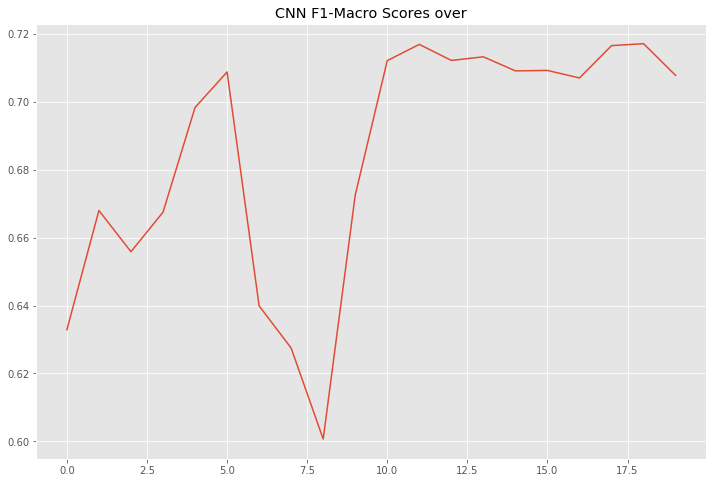

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(cnn_f1_scores)
plt.title('CNN F1-Macro Scores over');

>We can notice that there are some dips in the curve, but overall it becomes steady at **0.71.**
Ther performance of the test set is also similar.

In [54]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 
with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    test_predictions = []
    for idx in range(0,len(test_docs),batch_size):
        x_data = build_mini_batch(test_docs[idx:idx+batch_size], word_vectors)
        if x_data.shape[0] == 0: continue # to avoid empty batch
        x_tensor = torch.tensor(x_data, dtype=torch.float)
#             print(x_tensor.shape)
        if gpu:
            x_tensor = x_tensor.to('cuda')
        y_pred = model(x_tensor)#.cpu().detach().numpy()
        if gpu: y_pred = y_pred.to('cuda')
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
#             pred_labels = [np.argmax(entry) for entry in y_pred]
        test_predictions += pred_labels
        # print(pred_labels)
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='macro')
    print('The macro-F1 on dev set is {}'.format(f1))

The macro-F1 on dev set is 0.7153876065667518


From the above set of results, next we are going to look into combination of CNN & RNN network. To see if there's an improvement in the performance.

<a id="5d"></a>
## **iv. Convolutional Recurrent Neural Network with pre-trained embeddings**


Here we're going to use the previous GloVe embeddings and pass them through an LSTM Layer followed by some convolutions and fully connected.  
The architecture is shown below:

In [17]:
# then we define the RNN-based classifier
import torch
import torch.nn as nn

class ConvRNN_Classifier(nn.Module):
    def __init__(self, embd_dim, hidden_dim, model_type, cls_num, pooler_type, filter_size_list, filter_num_list, dropout, gpu):
        super(ConvRNN_Classifier, self).__init__()
        assert model_type in ['rnn','lstm','bilstm','gru']
        assert pooler_type in ['max','avg']
        self.embd_dim = embd_dim
        self.hidden_dim = hidden_dim
        if model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, 
                               bidirectional=True, dropout=dropout)
        else: # model_type == 'gru'
            self.rnn = nn.GRU(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, 
                              dropout=dropout, bidirectional=True, num_layers=2)
        self.convs = self.build_convs(filter_size_list, filter_num_list, gpu)    
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(np.sum(filter_num_list), 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, cls_num)
        self.gpu = gpu
        
        # rnn type
        
        # map from rnn output to logits
#         if model_type == 'linear':
#             self.fc = nn.Linear(2*hidden_dim, cls_num)
#         else:
#             self.fc = nn.Linear(hidden_dim, cls_num)
#         # pooler type
#         self.pooler_type = pooler_type
        # gpu or not
        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def build_convs(self, f_sizes, f_nums, gpu):
        convs = nn.ModuleList()
        for fs, fn in zip(f_sizes, f_nums):
            padding_size = fs-1
            m = nn.Conv1d(self.hidden_dim, fn, fs, stride=padding_size,padding=padding_size)
            if gpu: m.to('cuda')
            convs.append(m)
        return convs
        
    def get_conv_output(self, input_matrix, conv, gpu):
        # step 1: compute convolution 
        input_matrix = torch.transpose(input_matrix, 1, 2)
#         print('input_mat_conv', input_matrix.shape, 'self.embd_dim', self.embd_dim)
        assert input_matrix.shape[1] == self.hidden_dim
        if gpu:
            input_matrix = input_matrix.to('cuda')
        conv_output = conv(input_matrix)
        # step 2: pass through an activation function 
        conv_relu = self.tanh(conv_output)
        # step 3: max-over-time pooling
        maxp = nn.MaxPool1d(conv_relu.shape[2])
        maxp_output = maxp(conv_relu)
        return maxp_output
    
    def forward(self, input_matrix):
#         print('ip mat', input_matrix.shape)
        token_num = input_matrix.shape[1]
#         print('token_num', token_num)
        hidden_vecs = self.rnn(input_matrix)[0]
#         print('hidden', hidden_vecs.shape)
#         print(hidden_vecs)
        cnn_repr = torch.tensor([])
        if self.gpu: cnn_repr = cnn_repr.to('cuda')
        for cv in self.convs:
            cv_output = self.get_conv_output(hidden_vecs, cv, self.gpu)
            cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        # print(cnn_repr.shape)
        
#         cnn_repr = torch.tensor([])
#         if self.gpu: cnn_repr = cnn_repr.to('cuda')
#         for cv in self.convs:
#             cv_output = self.get_conv_output(cnn_repr, cv, self.gpu)
#             cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        
        after_dp = self.dropout(cnn_repr.squeeze())
        fc1_out = self.relu1(self.fc1(after_dp))
        fc2_out = self.relu2(self.fc2(fc1_out))
        logit = self.fc3(fc2_out)
        # the CrossEntropyLoss provided by pytorch includes softmax; so you do not need to include a softmax layer in your net
        return logit

# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 300
hidden_dim = 300
rnn_type = 'lstm'
pooler_type = 'avg'
dropout = 0.2

# embd_dim = 300
# hidden_dim = 150
# rnn_type = 'gru'
# pooler_type = 'max'
# dropout = 0.1
gpu = True

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    oov_vec = oov_vec = np.random.rand(embd_dim)
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    
    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*word_vec_dim)
        
    return np.array(vecs)

def build_mini_batch(sent_list, word_vectors):
    tokenized_sents = [word_tokenize(ss.lower()) for ss in sent_list]
    largest_len = np.max([len(tokens) for tokens in tokenized_sents])
    text_vecs = []
    for ts in tokenized_sents:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
#     print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)

def make_batch_prediction(sent_list, word_vectors, model, use_gpu=False):
    batch = build_mini_batch(sent_list, word_vectors)
#     print(batch[0].shape)
    batch_logits = torch.tensor([])
    if use_gpu: batch_logits = batch_logits.to('cuda')
    for i in range(batch.shape[0]):
        input_sents = torch.from_numpy(batch[i]).float()
        if use_gpu:
            input_sents = input_sents.to('cuda')
#         print(input_sents.unsqueeze(0).shape)
        logits = model(input_sents.unsqueeze(0))
        batch_logits = torch.cat( (batch_logits, logits) )
    return batch_logits.view(batch.shape[0],-1)
  
# dropout_rate = 0.1 # dropout rate
filter_sizes = [2, 2, 3, 3, 4]
filter_nums = [128, 192, 192, 256, 512]

    # sanity check 
model = ConvRNN_Classifier(embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, filter_sizes, filter_nums, dropout, gpu)
print(model)
batch_pred = make_batch_prediction(
    ['hello world!','hello','another test sentence this is'],
    word_vectors, model, gpu)
# print(batch_pred)

ConvRNN_Classifier(
  (rnn): LSTM(300, 300, batch_first=True, dropout=0.8)
  (convs): ModuleList(
    (0): Conv1d(300, 128, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(300, 192, kernel_size=(2,), stride=(1,), padding=(1,))
    (2): Conv1d(300, 192, kernel_size=(3,), stride=(2,), padding=(2,))
    (3): Conv1d(300, 256, kernel_size=(3,), stride=(2,), padding=(2,))
    (4): Conv1d(300, 512, kernel_size=(4,), stride=(3,), padding=(3,))
  )
  (tanh): Tanh()
  (dropout): Dropout(p=0.8, inplace=False)
  (fc1): Linear(in_features=1280, out_features=96, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=96, out_features=48, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=48, out_features=2, bias=True)
)


/home/archie/anaconda3/envs/pt/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [18]:
train_ratio = pd.Series(train_labels).value_counts()
train_ratio = train_ratio*100/train_ratio.sum()
print('Train Labels Distribution %\n', train_ratio.to_dict(), '\n')
test_ratio = pd.Series(dev_labels).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Dev Labels Distribution %\n', test_ratio.to_dict(), '\n')

test_ratio = pd.Series(test_labels).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Hold Out Labels Distribution %\n', test_ratio.to_dict(), '\n')

train_ratio = pd.Series(train_labels).value_counts()
print(train_ratio.to_dict())

weight_for_non_propaganda = (1 / train_ratio[1])*(train_ratio[0]+train_ratio[1])/2.0 
weight_for_propaganda = (1 / train_ratio[0])*(train_ratio[0]+train_ratio[1])/2.0

weight_for_propaganda, weight_for_non_propaganda

Train Labels Distribution %
 {0: 71.50334399534748, 1: 28.496656004652515} 

Dev Labels Distribution %
 {0: 73.31007413868295, 1: 26.68992586131705} 

Hold Out Labels Distribution %
 {0: 73.31007413868295, 1: 26.68992586131705} 

{0: 4918, 1: 1960}


(0.6992679951199675, 1.754591836734694)

In [ ]:
# dropout_rate = 0.5 # dropout rate
# filter_sizes = [2, 3, 4]
# filter_nums = [64]*len(filter_sizes)

gpu = True # whether use gpu to accelerate the training
model = ConvRNN_Classifier(embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, filter_sizes, filter_nums, dropout, gpu)
print(model)
# loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss
loss_fnc = nn.CrossEntropyLoss(weight=torch.Tensor([weight_for_non_propaganda, weight_for_propaganda]).cuda())

# hyper parameters
n_epochs = 20 # number of epoch (i.e. number of iterations)
batch_size = 64
lr = 1e-3 # initial learning rate

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) # after each epoch, the learning rate is discounted to its 95%

In [20]:
# training the CNN model

best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm_gui, tqdm_notebook, tqdm, notebook

In [ ]:
crnn_f1 = []
best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm, notebook
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# counter = 0
for epoch_i in range(n_epochs):
    print('epoch {}/{}'.format(epoch_i, n_epochs))
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    train_predictions = []
    for idx in notebook.tqdm(range(0,len(train_docs),batch_size)):
#         counter += 1
        # Step 0: Get the data
        sents = train_docs[idx:idx+batch_size]
        if len(sents) == 0: break
        y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = make_batch_prediction(sents, word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        train_predictions += pred_labels
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()
        
        # Step 4+: clip the gradient, to avoid gradient explosion
        nn.utils.clip_grad_value_(model.parameters(), clip_value=3.)

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    pre, rec, f1, _ = precision_recall_fscore_support(train_labels, train_predictions, average='weighted')
#     writer.add_scalar('F-1/train', f1, counter)
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        predictions = []
        test_docs = dev_docs
        test_labels = dev_labels
        
        for idx in range(0,len(test_docs),batch_size):
            y_pred = make_batch_prediction(
                test_docs[idx:idx+batch_size], word_vectors, model, gpu)
            pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
            predictions += pred_labels
        pre, rec, f1, _ = precision_recall_fscore_support(test_labels, predictions,average='weighted')
        print('\n---> after epoch {} the macro-F1 on dev set is {}'.format(epoch_i, f1))
        crnn_f1.append(f1)
        for param_group in optimizer.param_groups:
            print('learning rate', param_group['lr'])
#         writer.add_scalar('F-1/test', f1, counter)

        # save the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            print('best model updated; new best macro-F1',f1)
    
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()

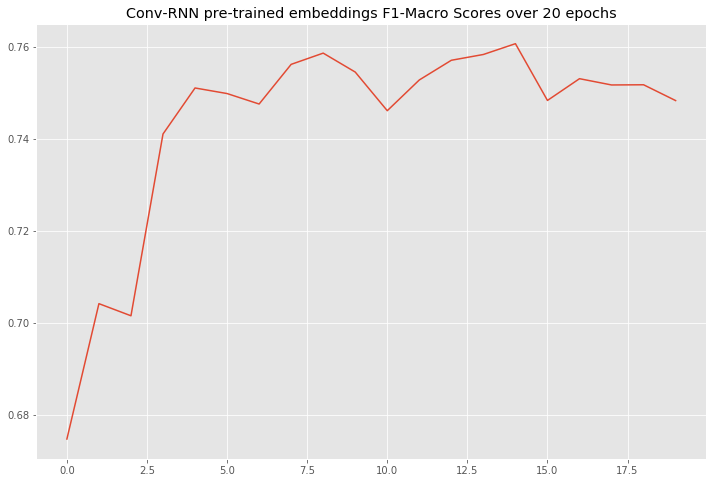

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(crnn_f1)
plt.title('Conv-RNN pre-trained embeddings F1-Macro Scores over 20 epochs');

>From the above plot we can see that this network is much more stable compared to the rest.

In [33]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 

with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    predictions = []
#     test_docs = test_docs
#     test_labels = dev_labels

    for idx in range(0,len(test_docs),batch_size):
        y_pred = make_batch_prediction(
            test_docs[idx:idx+batch_size], word_vectors, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        predictions += pred_labels
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, predictions,average='macro')
    print('The macro-F1 on dev set is {}'.format(f1))

The macro-F1 on dev set is 0.679910858219928


<a id="5e"></a>
## **v. Custom Embeddings Convolutional Recurrent Neural Network**


As of now we were using pre-trained word embeddings.
Now we are going to see the performance of the previous network and the word embeddings will be trained from scratch.

In order to do so, we need to follow the below steps before training:
- *Create unique id's for each word*
- *Convert the sequence of words into their corresponding id form*

In [58]:
print('Raw Text')
print('*'*10)
print(df_joined_padded_text.iloc[0][0])
print('-'*100)
print('After Conversion')
print('*'*17)
print(df_joined_padded_text.iloc[0][1])

Raw Text
**********
major new study homeschooling spikes due to school violence farleft bias we have a daughter still in high school and three in grade school
----------------------------------------------------------------------------------------------------
After Conversion
*****************
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  870   68  871  489 1728  609    2  128  309 1697 1214   29   31    6
 1456  236    4  596  128    5  496    4 4495  128]


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_joined_padded_text, df_label, test_size=0.4, random_state=42)

In [32]:
print('Training set size {}'.format(len(X_train)))
print('Test set size {}'.format(len(X_test)))

Training set size 6878
Test set size 4586


In [33]:
X_dev, X_ho, y_dev, y_ho = train_test_split(X_test, y_test, test_size=0.5, random_state=518123)

In [34]:
print('Training set size {}'.format(len(X_dev)))
print('Test set size {}'.format(len(X_ho)))

Training set size 2293
Test set size 2293


In [35]:
train_ratio = pd.Series(y_train).value_counts()
train_ratio = train_ratio*100/train_ratio.sum()
print('Train Labels Distribution %\n', train_ratio.to_dict(), '\n')
test_ratio = pd.Series(y_dev).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Dev Labels Distribution %\n', test_ratio.to_dict(), '\n')

test_ratio = pd.Series(y_dev).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Hold Out Labels Distribution %\n', test_ratio.to_dict(), '\n')

Train Labels Distribution %
 {0: 71.41610933410875, 1: 28.583890665891246} 

Dev Labels Distribution %
 {0: 73.13563017880506, 1: 26.86436982119494} 

Hold Out Labels Distribution %
 {0: 73.13563017880506, 1: 26.86436982119494} 



In [38]:
# then we define the RNN-based classifier
import torch
import torch.nn as nn

class ConvRNN_Classifier(nn.Module):
    def __init__(self, vocab_size, embd_dim, hidden_dim, model_type, cls_num, pooler_type, filter_size_list, filter_num_list, dropout, gpu):
        super(ConvRNN_Classifier, self).__init__()
        assert model_type in ['rnn','lstm','bilstm','gru']
        assert pooler_type in ['max','avg']
        
        self.embd_dim = embd_dim
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embd_dim)
        
        # rnn type
        if model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, 
                               bidirectional=True, dropout=dropout)
        else: # model_type == 'gru'
            self.rnn = nn.GRU(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, 
                              dropout=dropout, bidirectional=True, num_layers=2)
        
        self.convs = self.build_convs(filter_size_list, filter_num_list, gpu)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(np.sum(filter_num_list), 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, cls_num)
        self.gpu = gpu
                
        self.relu = nn.ReLU()
        
        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def build_convs(self, f_sizes, f_nums, gpu):
        convs = nn.ModuleList()
        for fs, fn in zip(f_sizes, f_nums):
            padding_size = fs-1
            m = nn.Conv1d(self.hidden_dim, fn, fs, stride=padding_size,padding=padding_size)
            if gpu: m.to('cuda')
            convs.append(m)
        return convs
        
    def get_conv_output(self, input_matrix, conv, gpu):
        # step 1: compute convolution 
        input_matrix = torch.transpose(input_matrix, 1, 2)
#         print('input_mat_conv', input_matrix.shape, 'self.embd_dim', self.embd_dim)
        assert input_matrix.shape[1] == self.hidden_dim
        if gpu:
            input_matrix = input_matrix.to('cuda')
        conv_output = conv(input_matrix)
        # step 2: pass through an activation function 
        conv_relu = self.tanh(conv_output)
        # step 3: max-over-time pooling
        maxp = nn.MaxPool1d(conv_relu.shape[2])
        maxp_output = maxp(conv_relu)
        return maxp_output
    
    def forward(self, input_matrix):
#         print('ip mat', input_matrix.shape)
        token_num = input_matrix.shape[1]
#         print('token_num', token_num)
        embedding = self.embedding(input_matrix)
        hidden_vecs = self.rnn(embedding)[0]
#         print('hidden', hidden_vecs.shape)
#         print(hidden_vecs)
        cnn_repr = torch.tensor([])
        if self.gpu: cnn_repr = cnn_repr.to('cuda')
        for cv in self.convs:
            cv_output = self.get_conv_output(hidden_vecs, cv, self.gpu)
            cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        # print(cnn_repr.shape)
        
#         cnn_repr = torch.tensor([])
#         if self.gpu: cnn_repr = cnn_repr.to('cuda')
#         for cv in self.convs:
#             cv_output = self.get_conv_output(cnn_repr, cv, self.gpu)
#             cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        
        after_dp = self.dropout(cnn_repr.squeeze())
        fc1_out = self.relu1(self.fc1(after_dp))
        fc2_out = self.relu2(self.fc2(fc1_out))
        logit = self.fc3(fc2_out)
        # the CrossEntropyLoss provided by pytorch includes softmax; so you do not need to include a softmax layer in your net
        return logit

In [ ]:
# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 500
hidden_dim = 300
rnn_type = 'lstm'
pooler_type = 'max'
dropout = 0.2

# embd_dim = 300
# hidden_dim = 150
# rnn_type = 'gru'
# pooler_type = 'max'
# dropout = 0.1
gpu = True

def make_batch_prediction(batch, model, use_gpu=False):
    batch_logits = torch.tensor([])
    if use_gpu: 
        batch_logits = batch_logits.to('cuda')
    for i in range(batch.shape[0]):
        input_sents = torch.from_numpy(batch[i]).float()
        if use_gpu:
            input_sents = input_sents.to('cuda')
#         print(input_sents.unsqueeze(0).shape)
        logits = model(input_sents.unsqueeze(0).long())
        batch_logits = torch.cat( (batch_logits, logits) )
    return batch_logits.view(batch.shape[0],-1)
  
dropout_rate = 0.2# dropout rate
filter_sizes = [2, 2, 3, 3, 4]
filter_nums = [128, 192, 192, 256, 512]
vocab_size = len(word_to_id)+1
    # sanity check 
model = ConvRNN_Classifier(vocab_size, embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, filter_sizes, filter_nums, dropout, gpu)
print(model)
batch_pred = make_batch_prediction(
    np.array(X_train)[:3], model, gpu)
# print(batch_pred)

### **Architecture**

The netowrk consists of an embedding layer, followed by a LSTM layer. 
Multuple convolutions are taken from the LSTM Layer.   
They are concatenated and fed to a deep fully connected layer.  
The architecture of the network is shown below:

In [40]:
# dropout_rate = 0.5 # dropout rate
# filter_sizes = [2, 3, 4]
# filter_nums = [64]*len(filter_sizes)

gpu = True # whether use gpu to accelerate the training
model = ConvRNN_Classifier(vocab_size, embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, filter_sizes, filter_nums, dropout, gpu)
print(model)
# loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss
loss_fnc = nn.CrossEntropyLoss(weight=torch.Tensor([weight_for_non_propaganda, weight_for_propaganda]).cuda())

# hyper parameters
n_epochs = 20 # number of epoch (i.e. number of iterations)
batch_size = 32
lr = 1e-3 # initial learning rate

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95) # after each epoch, the learning rate is discounted to its 95%

ConvRNN_Classifier(
  (embedding): Embedding(16950, 500)
  (rnn): LSTM(500, 300, batch_first=True, dropout=0.2)
  (convs): ModuleList(
    (0): Conv1d(300, 128, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(300, 192, kernel_size=(2,), stride=(1,), padding=(1,))
    (2): Conv1d(300, 192, kernel_size=(3,), stride=(2,), padding=(2,))
    (3): Conv1d(300, 256, kernel_size=(3,), stride=(2,), padding=(2,))
    (4): Conv1d(300, 512, kernel_size=(4,), stride=(3,), padding=(3,))
  )
  (tanh): Tanh()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1280, out_features=96, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=96, out_features=48, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=48, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm, notebook
from torch.utils.tensorboard import SummaryWriter
f1_scores = []
for epoch_i in range(n_epochs):
    print('epoch {}/{}'.format(epoch_i, n_epochs))
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    train_predictions = []
    for idx in notebook.tqdm(range(0,len(np.array(X_train)),batch_size)):
        # Step 0: Get the data
        sents = np.array(X_train)[idx:idx+batch_size]
        if len(sents) == 0: break
        y_target = torch.tensor([np.array(y_train)[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = make_batch_prediction(sents, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        train_predictions += pred_labels
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()
        
        # Step 4+: clip the gradient, to avoid gradient explosion
        nn.utils.clip_grad_value_(model.parameters(), clip_value=3.)

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    pre, rec, f1, _ = precision_recall_fscore_support(y_train, train_predictions, average='weighted')
#     writer.add_scalar('F-1/train', f1, counter)
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        predictions = []
#         test_docs = dev_docs
#         test_labels = dev_labels
        
        for idx in range(0,len(np.array(X_dev)),batch_size):
            y_pred = make_batch_prediction(np.array(X_dev)[idx:idx+batch_size], model, gpu)
            pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
            predictions += pred_labels
        pre, rec, f1, _ = precision_recall_fscore_support(y_dev, predictions,average='weighted')
        print('\n---> after epoch {} the macro-F1 on dev set is {}'.format(epoch_i, f1))
        
        f1_scores.append(f1)
#         for param_group in optimizer.param_groups:
#             print('learning rate', param_group['lr'])
#         writer.add_scalar('F-1/test', f1, counter)

        # save the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            print('best model updated; new best macro-F1',f1)
    
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()

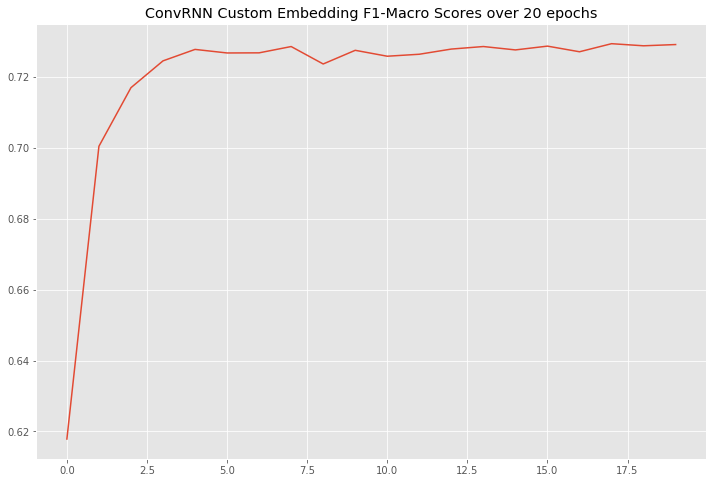

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(f1_scores)
plt.title('ConvRNN Custom Embedding F1-Macro Scores over 20 epochs');

>From the above plot, we can see that there's a gradual rise of the validation f1-score and it stabilizes around **0.72** after few epochs. Even though the performance in the hold-out test set is comparatively bad, we'll be using this model as this has higher generalization than the rest.

In [48]:
# test on the test set
test_predictions = []
# load the best model weights
model.load_state_dict(best_model) 

with torch.no_grad(): # let pytorch know that no gradient should be computed
    model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
    predictions = []
#     test_docs = test_docs
#     test_labels = dev_labels

    for idx in range(0,len(np.array(X_ho)),batch_size):
        y_pred = make_batch_prediction(np.array(X_ho)[idx:idx+batch_size], model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        predictions += pred_labels
    pre, rec, f1, _ = precision_recall_fscore_support(np.array(y_ho), predictions,average='macro')
    print('the macro-F1 on dev set is {}'.format(f1))

the macro-F1 on dev set is 0.6393255763843999


<a id="6"></a>
## **6. Final Model Build**

We'll train the network with a 80% - 20% split data and save it as a pickle file.

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(f1_scores)
plt.title('ConvRNN Custom Embedding F1-Macro Scores over 25 epochs');plt.figure(figsize=(12, 8))
plt.plot(f1_scores)
plt.title('ConvRNN Custom Embedding F1-Macro Scores over 25 epochs');plt.figure(figsize=(12, 8))
plt.plot(f1_scores)
plt.title('ConvRNN Custom Embedding F1-Macro Scores over 25 epochs');from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_joined_padded_text, df_label, test_size=0.2, random_state=518123)

X_train[:2]

print('Training set size {}'.format(len(X_train)))
print('Test set size {}'.format(len(X_test)))

# X_dev, X_ho, y_dev, y_ho = train_test_split(X_test, y_test, test_size=0.5, random_state=518123)

# print('Training set size {}'.format(len(X_dev)))
# print('Test set size {}'.format(len(X_ho)))

train_ratio = pd.Series(y_train).value_counts()
train_ratio = train_ratio*100/train_ratio.sum()
print('Train Labels Distribution %\n', train_ratio.to_dict(), '\n')
test_ratio = pd.Series(y_test).value_counts()
test_ratio = test_ratio*100/test_ratio.sum()
print('Dev Labels Distribution %\n', test_ratio.to_dict(), '\n')

# test_ratio = pd.Series(y_dev).value_counts()
# test_ratio = test_ratio*100/test_ratio.sum()
# print('Hold Out Labels Distribution %\n', test_ratio.to_dict(), '\n')

train_ratio = pd.Series(y_train).value_counts()
train_ratio.to_dict()

weight_for_non_propaganda = (1 / train_ratio[1])*(train_ratio[0]+train_ratio[1])/2.0 
weight_for_propaganda = (1 / train_ratio[0])*(train_ratio[0]+train_ratio[1])/2.0

weight_for_propaganda, weight_for_non_propaganda

# then we define the RNN-based classifier
import torch
import torch.nn as nn

class ConvRNN_Classifier(nn.Module):
    def __init__(self, vocab_size, embd_dim, hidden_dim, model_type, cls_num, pooler_type, filter_size_list, filter_num_list, dropout, gpu):
        super(ConvRNN_Classifier, self).__init__()
        assert model_type in ['rnn','lstm','bilstm','gru']
        assert pooler_type in ['max','avg']
        
        self.embd_dim = embd_dim
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embd_dim)
        
        # rnn type
        if model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout)
        elif model_type == 'bilstm':
            self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, 
                               bidirectional=True, dropout=dropout)
        else: # model_type == 'gru'
            self.rnn = nn.GRU(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, 
                              dropout=dropout, bidirectional=True, num_layers=2)
        
        self.convs = self.build_convs(filter_size_list, filter_num_list, gpu)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(np.sum(filter_num_list), 96)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(96, 48)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(48, cls_num)
        self.gpu = gpu
                
        self.relu = nn.ReLU()
        
        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def build_convs(self, f_sizes, f_nums, gpu):
        convs = nn.ModuleList()
        for fs, fn in zip(f_sizes, f_nums):
            padding_size = fs-1
            m = nn.Conv1d(self.hidden_dim, fn, fs, stride=padding_size,padding=padding_size)
            if gpu: m.to('cuda')
            convs.append(m)
        return convs
        
    def get_conv_output(self, input_matrix, conv, gpu):
        # step 1: compute convolution 
        input_matrix = torch.transpose(input_matrix, 1, 2)
#         print('input_mat_conv', input_matrix.shape, 'self.embd_dim', self.embd_dim)
        assert input_matrix.shape[1] == self.hidden_dim
        if gpu:
            input_matrix = input_matrix.to('cuda')
        conv_output = conv(input_matrix)
        # step 2: pass through an activation function 
        conv_relu = self.tanh(conv_output)
        # step 3: max-over-time pooling
        maxp = nn.MaxPool1d(conv_relu.shape[2])
        maxp_output = maxp(conv_relu)
        return maxp_output
    
    def forward(self, input_matrix):
#         print('ip mat', input_matrix.shape)
        token_num = input_matrix.shape[1]
#         print('token_num', token_num)
        embedding = self.embedding(input_matrix)
        hidden_vecs = self.rnn(embedding)[0]
#         print('hidden', hidden_vecs.shape)
#         print(hidden_vecs)
        cnn_repr = torch.tensor([])
        if self.gpu: cnn_repr = cnn_repr.to('cuda')
        for cv in self.convs:
            cv_output = self.get_conv_output(hidden_vecs, cv, self.gpu)
            cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        # print(cnn_repr.shape)
        
#         cnn_repr = torch.tensor([])
#         if self.gpu: cnn_repr = cnn_repr.to('cuda')
#         for cv in self.convs:
#             cv_output = self.get_conv_output(cnn_repr, cv, self.gpu)
#             cnn_repr = torch.cat((cnn_repr, cv_output), dim=1)
        
        after_dp = self.dropout(cnn_repr.squeeze())
        fc1_out = self.relu1(self.fc1(after_dp))
        fc2_out = self.relu2(self.fc2(fc1_out))
        logit = self.fc3(fc2_out)
        # the CrossEntropyLoss provided by pytorch includes softmax; so you do not need to include a softmax layer in your net
        return logit

# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 500
hidden_dim = 300
rnn_type = 'lstm'
pooler_type = 'max'
dropout = 0.2

# embd_dim = 300
# hidden_dim = 150
# rnn_type = 'gru'
# pooler_type = 'max'
# dropout = 0.1
gpu = True

def make_batch_prediction(batch, model, use_gpu=False):
    batch_logits = torch.tensor([])
    if use_gpu: 
        batch_logits = batch_logits.to('cuda')
    for i in range(batch.shape[0]):
        input_sents = torch.from_numpy(batch[i]).float()
        if use_gpu:
            input_sents = input_sents.to('cuda')
#         print(input_sents.unsqueeze(0).shape)
        logits = model(input_sents.unsqueeze(0).long())
        batch_logits = torch.cat( (batch_logits, logits) )
    return batch_logits.view(batch.shape[0],-1)
  
dropout_rate = 0.2# dropout rate
filter_sizes = [2, 2, 3, 3, 4]
filter_nums = [128, 192, 192, 256, 512]
vocab_size = len(word_to_id)+1
    # sanity check 
model = ConvRNN_Classifier(vocab_size, embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, filter_sizes, filter_nums, dropout, gpu)
print(model)
batch_pred = make_batch_prediction(
    np.array(X_train)[:3], model, gpu)
# print(batch_pred)

# dropout_rate = 0.5 # dropout rate
# filter_sizes = [2, 3, 4]
# filter_nums = [64]*len(filter_sizes)

gpu = True # whether use gpu to accelerate the training
model = ConvRNN_Classifier(vocab_size, embd_dim, hidden_dim, rnn_type, len(label_dic), pooler_type, filter_sizes, filter_nums, dropout, gpu)
print(model)
# loss_fnc = torch.nn.CrossEntropyLoss() # cross entropy loss
loss_fnc = nn.CrossEntropyLoss(weight=torch.Tensor([weight_for_non_propaganda, weight_for_propaganda]).cuda())

# hyper parameters
n_epochs = 25 # number of epoch (i.e. number of iterations)
batch_size = 32
lr = 1e-3 # initial learning rate

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95) # after each epoch, the learning rate is discounted to its 95%

# training the CNN model

best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm_gui, tqdm_notebook, tqdm, notebook

best_f1 = -1.
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from nltk.tokenize import word_tokenize
from tqdm import tqdm, notebook
from torch.utils.tensorboard import SummaryWriter
f1_scores = []
for epoch_i in range(n_epochs):
    print('epoch {}/{}'.format(epoch_i, n_epochs))
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    train_predictions = []
    for idx in notebook.tqdm(range(0,len(np.array(X_train)),batch_size)):
        # Step 0: Get the data
        sents = np.array(X_train)[idx:idx+batch_size]
        if len(sents) == 0: break
        y_target = torch.tensor([np.array(y_train)[idx:idx+batch_size]], dtype=torch.int64).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = make_batch_prediction(sents, model, gpu)
        pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        train_predictions += pred_labels
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()
        
        # Step 4+: clip the gradient, to avoid gradient explosion
        nn.utils.clip_grad_value_(model.parameters(), clip_value=3.)

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    pre, rec, f1, _ = precision_recall_fscore_support(y_train, train_predictions, average='weighted')
#     writer.add_scalar('F-1/train', f1, counter)
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        predictions = []
#         test_docs = dev_docs
#         test_labels = dev_labels
        
        for idx in range(0,len(np.array(X_test)),batch_size):
            y_pred = make_batch_prediction(np.array(X_test)[idx:idx+batch_size], model, gpu)
            pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
            predictions += pred_labels
        pre, rec, f1, _ = precision_recall_fscore_support(y_test, predictions,average='weighted')
        print('\n---> after epoch {} the macro-F1 on dev set is {}'.format(epoch_i, f1))
        
        f1_scores.append(f1)
#         for param_group in optimizer.param_groups:
#             print('learning rate', param_group['lr'])
#         writer.add_scalar('F-1/test', f1, counter)

        # save the best model
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            print('best model updated; new best macro-F1',f1)
    
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()

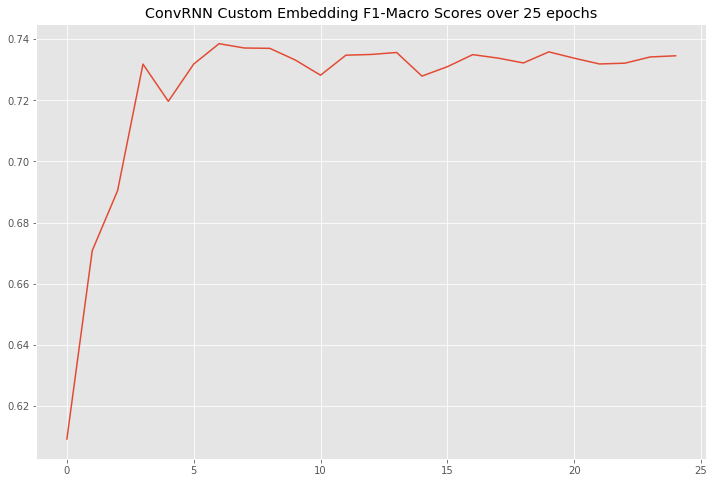

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(f1_scores)
plt.title('ConvRNN Custom Embedding F1-Macro Scores over 25 epochs');

>We see a similar performance in the final trianig process as well.

In [ ]:
import pickle

    'input_dim': embd_dim,
    'hidden_dim':hidden_dim,
    'dropout_rate': dropout,
    'neural_weights': best_model,
    'word_to_id':word_to_id,
    'model_type':rnn_type,
    'filter_nums': filter_nums,
    'filter_sizes': filter_sizes,
    'pooler': pooler_type,
    'vocab_size': vocab_size,
    'num_class':2,
    'gpu':False,
    'max_seq_length':seq_lengths.max()
    
}
save_path = open("cw2_crnn_custom_final.pickle","wb")
pickle.dump(all_info_want_to_save, save_path)
save_path.close()

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/Show Code."></form>''')